# Segmentation Client - RFM + Satisfaction + Catégories


## 1. Création d'une base de données RFM + Satisfaction + Catégories

Importation des Données

In [ ]:
import pandas as pd

olist_customers_dataset = pd.read_csv('/home/edward/Project 4/olist_customers_dataset.csv', sep=',')
olist_geolocation_dataset = pd.read_csv('/home/edward/Project 4/olist_geolocation_dataset.csv', sep=',')
olist_order_items_dataset = pd.read_csv('/home/edward/Project 4/olist_order_items_dataset.csv', sep=',')
olist_order_payments_dataset = pd.read_csv('/home/edward/Project 4/olist_order_payments_dataset.csv', sep=',')
olist_order_reviews_dataset = pd.read_csv('/home/edward/Project 4/olist_order_reviews_dataset.csv', sep=',')
olist_orders_dataset = pd.read_csv('/home/edward/Project 4/olist_orders_dataset.csv', sep=',')
olist_products_dataset = pd.read_csv('/home/edward/Project 4/olist_products_dataset.csv', sep=',')
olist_sellers_dataset = pd.read_csv('/home/edward/Project 4/olist_sellers_dataset.csv', sep=',')
product_category_name_translation = pd.read_csv('/home/edward/Project 4/product_category_name_translation.csv', sep=',')

All_Datasets = {'olist_customers_dataset' : olist_customers_dataset, 'olist_geolocation_dataset' : olist_geolocation_dataset, 'olist_order_items_dataset' : olist_order_items_dataset, 'olist_order_payments_dataset' : olist_order_payments_dataset, 'olist_order_reviews_dataset' : olist_order_reviews_dataset, 'olist_orders_dataset' : olist_orders_dataset, 'olist_products_dataset' : olist_products_dataset, 'olist_sellers_dataset' : olist_sellers_dataset, 'product_category_name_translation' : product_category_name_translation}

In [ ]:
# Merge Different Dataframes

Data1 = pd.merge(olist_customers_dataset, olist_orders_dataset)
Data1 = pd.merge(Data1, olist_orders_dataset)
Data2 = pd.merge(olist_order_payments_dataset, olist_order_items_dataset)
Data2 = pd.merge(Data2, olist_order_reviews_dataset)
Data = pd.merge(Data1, Data2)
Data = pd.merge(Data, olist_products_dataset)
Data = pd.merge(Data, olist_sellers_dataset)

# Drop Duplicate Orders

Data.drop_duplicates(subset = "order_id", keep = False, inplace = True)

Création d'une base deonnées avec RFM+ Satisfaction + Variables Binaires d'appartenance à chaque catégorie

In [ ]:
from datetime import datetime
from datetime import date

Data['order_delivered_customer_date'] = pd.to_datetime(Data['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# Do a RFM dataframe (Recency, Frequency, Amount) + Mean Review + Main Categories

Data = Data.dropna(subset=['order_delivered_customer_date'])

Data.drop_duplicates(subset = "order_id", keep = False, inplace = True)

UniqueIndividuals = Data.customer_unique_id.unique()
    

#  Count for each individual, the number of orders, the date of the last order, the total amount spent, and the satisfaction level

print(len(UniqueIndividuals))

List = []

for i in range(len(UniqueIndividuals)):
    Blank = []
    Blank.append(UniqueIndividuals[i])
    Blank.append(Data['order_delivered_customer_date'][Data["customer_unique_id"] == UniqueIndividuals[i]].max())
    Blank.append(len(Data[Data["customer_unique_id"] == UniqueIndividuals[i]]))
    Blank.append(Data['price'][Data["customer_unique_id"] == UniqueIndividuals[i]].sum())
    Blank.append(Data['review_score'][Data["customer_unique_id"] == UniqueIndividuals[i]].mean())
    Blank.append(Data['customer_city'][Data["customer_unique_id"] == UniqueIndividuals[i]].iloc[-1])
    Blank.append(Data['customer_state'][Data["customer_unique_id"] == UniqueIndividuals[i]].iloc[-1])
    Blank.append(Data['payment_type'][Data["customer_unique_id"] == UniqueIndividuals[i]].iloc[-1])
    Blank.append(Data['product_category_name'][Data["customer_unique_id"] == UniqueIndividuals[i]].iloc[-1])
    List.append(Blank)
    if i%1000 == 0:
        print(i)
        
# Create Empty DataFrame with only Individuals and their 'customer_unique_id'

Individuals = pd.DataFrame(List, columns = ['customer_unique_id', 'Recency', 'Frequency', 'Amount', 'Mean_review_score', 'City', 'State', 'Payment_Type', 'Category'])
        
Individuals.to_csv('/home/edward/IndividualsRFM_Categories.csv')

## 2. Division des données par date, et Target Encoding des variables catégoriques

J'importe les données RFM+Satisfaction+Catégories.

Ensuite je divise les données par tranches de 2 mois (selon commande la plus récente).

Puis je "concatenate" les tranches de 2 mois, d'abord de la plus ancienne vers la plus récente, et ensuite de la plus récente à la plus ancienne.

Enfin je fais 16 target encoding, un pour chaque variable catégorique (City, State, Payment_type, Category), et pour chaque target (Recency, Frequency, Amount, Satisfaction).




In [3]:
# Import Individuals data

import pandas as pd

NewIndividuals = pd.read_csv('/content/IndividualsRFM_Categories.csv', sep=',')
NewIndividuals = NewIndividuals.iloc[:,1::]

NewIndividuals.columns = ['customer_unique_id', 'Frequency', 'Recency', 'Amount', 'Mean_review_score', 'City', 'State', 'Payment_Type', 'Category']


# Change Rencency into numeric (number of days passed since 31/12/2015)

from sklearn.decomposition import KernelPCA
from datetime import datetime
from datetime import date

NewIndividuals['Recency'] = pd.to_datetime(NewIndividuals['Recency'], format='%Y-%m-%d %H:%M:%S')

NewIndividuals['Year'] = NewIndividuals['Recency'].dt.strftime('%Y')
NewIndividuals = NewIndividuals.dropna(subset=['Year'])
NewIndividuals['Year'] = pd.to_numeric(NewIndividuals['Year'])
NewIndividuals['Year'] = NewIndividuals['Year'] - NewIndividuals['Year'].min()

NewIndividuals['Months'] = NewIndividuals['Recency'].dt.strftime('%m')
NewIndividuals = NewIndividuals.dropna(subset=['Months'])
NewIndividuals['Months'] = pd.to_numeric(NewIndividuals['Months'])

NewIndividuals['Days'] = NewIndividuals['Recency'].dt.strftime('%d')
NewIndividuals = NewIndividuals.dropna(subset=['Days'])
NewIndividuals['Days'] = pd.to_numeric(NewIndividuals['Days'])

NewIndividuals['NumRecency'] = 365*NewIndividuals['Year'] + 30*NewIndividuals['Months'] + NewIndividuals['Days']

NewIndividuals['Year'] = NewIndividuals['Recency'].dt.strftime('%Y')
NewIndividuals['Year'] = pd.to_numeric(NewIndividuals['Year'])

NewIndividuals['Months'] = NewIndividuals['Recency'].dt.strftime('%m')
NewIndividuals['Months'] = pd.to_numeric(NewIndividuals['Months'])

NewIndividuals['Days'] = NewIndividuals['Recency'].dt.strftime('%d')
NewIndividuals['Days'] = pd.to_numeric(NewIndividuals['Days'])

NewIndividuals = NewIndividuals[['customer_unique_id', 'Year', 'Months', 'Days', 'Recency', 'Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City', 'State', 'Payment_Type', 'Category']]

Je divise les données par tranches de 2 mois.

Puis je fais une concatenation de la plus vielle à la plus récente.

Et enfin, je fais une concatenation de la plus récente à la plus récente.

In [4]:
# Divide data by slices of 2 months (according to latest order).

NewIndividuals_11 = NewIndividuals[NewIndividuals['Year'] < 2017]

NewIndividuals_10 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 0) & (NewIndividuals['Months'] <= 2)]
NewIndividuals_9 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 2) & (NewIndividuals['Months'] <= 4)]
NewIndividuals_8 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 4) & (NewIndividuals['Months'] <= 6)]
NewIndividuals_7 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 6) & (NewIndividuals['Months'] <= 8)]
NewIndividuals_6 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 8) & (NewIndividuals['Months'] <= 10)]
NewIndividuals_5 = NewIndividuals[(NewIndividuals['Year'] == 2017) & (NewIndividuals['Months'] > 10)]
                              
NewIndividuals_4 = NewIndividuals[(NewIndividuals['Year'] == 2018) & (NewIndividuals['Months'] > 0) & (NewIndividuals['Months'] <= 2)]
NewIndividuals_3 = NewIndividuals[(NewIndividuals['Year'] == 2018) & (NewIndividuals['Months'] > 2) & (NewIndividuals['Months'] <= 4)]
NewIndividuals_2 = NewIndividuals[(NewIndividuals['Year'] == 2018) & (NewIndividuals['Months'] > 4) & (NewIndividuals['Months'] <= 6)]
NewIndividuals_1 = NewIndividuals[(NewIndividuals['Year'] == 2018) & (NewIndividuals['Months'] > 6)]

# Store each 2 months slice into a list of DataFrames

DataFrames_Temporary = [NewIndividuals_1, NewIndividuals_2, NewIndividuals_3, NewIndividuals_4, NewIndividuals_5, NewIndividuals_6, NewIndividuals_7, NewIndividuals_8, NewIndividuals_9, NewIndividuals_10, NewIndividuals_11]

# Concatenate from oldest to most recent, and store each cumulated slice into a list.

DataFrames = [DataFrames_Temporary[-1]]

for i in range(1, len(DataFrames_Temporary)):
  DataFrames.append(pd.concat([DataFrames_Temporary[-i-1],DataFrames[-1]]))

# Concatenate from most recent to oldest, and store each cumulated slice into a list.

DataFrames_Latest = [DataFrames_Temporary[0]]

for i in range(1, len(DataFrames_Temporary)):
  DataFrames_Latest.append(pd.concat([DataFrames_Latest[i-1],DataFrames_Temporary[i]]))

Dates = ['10/16', '12/16', '02/17', '04/17', '06/17', '08/17', '10/17', '12/17', '02/18', '04/18', '06/18']

In [5]:
pip install category_encoders

Je fais 16 Target encoding dans les données cumulées chronologiquement, et dans les données cumulées anti-chronologiquement.

Je fais un target encoding pour chaque variable catégorique (City, State, Payment type, Product Type), et pour chaque target (Recency, Frequency, Amount, Satisfaction).

In [6]:
# Do 16 Target encodings : one for each Categorical variable and for each RFM+Satisfaction - in the chronologically cumulated datasets

from category_encoders import TargetEncoder

for i in range(len(DataFrames)):

  encoder = TargetEncoder()

  DataFrames[i]['City_Frequency'] = encoder.fit_transform(DataFrames[i]['City'], DataFrames[i]['Frequency'])
  DataFrames[i]['City_NumRecency'] = encoder.fit_transform(DataFrames[i]['City'], DataFrames[i]['NumRecency'])
  DataFrames[i]['City_Amount'] = encoder.fit_transform(DataFrames[i]['City'], DataFrames[i]['Amount'])
  DataFrames[i]['City_Review'] = encoder.fit_transform(DataFrames[i]['City'], DataFrames[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames[i]['State_Frequency'] = encoder.fit_transform(DataFrames[i]['State'], DataFrames[i]['Frequency'])
  DataFrames[i]['State_NumRecency'] = encoder.fit_transform(DataFrames[i]['State'], DataFrames[i]['NumRecency'])
  DataFrames[i]['State_Amount'] = encoder.fit_transform(DataFrames[i]['State'], DataFrames[i]['Amount'])
  DataFrames[i]['State_Review'] = encoder.fit_transform(DataFrames[i]['State'], DataFrames[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames[i]['Payment_Type_Frequency'] = encoder.fit_transform(DataFrames[i]['Payment_Type'], DataFrames[i]['Frequency'])
  DataFrames[i]['Payment_Type_NumRecency'] = encoder.fit_transform(DataFrames[i]['Payment_Type'], DataFrames[i]['NumRecency'])
  DataFrames[i]['Payment_Type_Amount'] = encoder.fit_transform(DataFrames[i]['Payment_Type'], DataFrames[i]['Amount'])
  DataFrames[i]['Payment_Type_Review'] = encoder.fit_transform(DataFrames[i]['Payment_Type'], DataFrames[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames[i]['Category_Frequency'] = encoder.fit_transform(DataFrames[i]['Category'], DataFrames[i]['Frequency'])
  DataFrames[i]['Category_NumRecency'] = encoder.fit_transform(DataFrames[i]['Category'], DataFrames[i]['NumRecency'])
  DataFrames[i]['Category_Amount'] = encoder.fit_transform(DataFrames[i]['Category'], DataFrames[i]['Amount'])
  DataFrames[i]['Category_Review'] = encoder.fit_transform(DataFrames[i]['Category'], DataFrames[i]['Mean_review_score'])




# Do 16 Target encodings : one for each Categorical variable and for each RFM+Satisfaction - in the anti-chronologically cumulated datasets

from category_encoders import TargetEncoder

for i in range(len(DataFrames_Latest)):

  encoder = TargetEncoder()

  DataFrames_Latest[i]['City_Frequency'] = encoder.fit_transform(DataFrames_Latest[i]['City'], DataFrames_Latest[i]['Frequency'])
  DataFrames_Latest[i]['City_NumRecency'] = encoder.fit_transform(DataFrames_Latest[i]['City'], DataFrames_Latest[i]['NumRecency'])
  DataFrames_Latest[i]['City_Amount'] = encoder.fit_transform(DataFrames_Latest[i]['City'], DataFrames_Latest[i]['Amount'])
  DataFrames_Latest[i]['City_Review'] = encoder.fit_transform(DataFrames_Latest[i]['City'], DataFrames_Latest[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames_Latest[i]['State_Frequency'] = encoder.fit_transform(DataFrames_Latest[i]['State'], DataFrames_Latest[i]['Frequency'])
  DataFrames_Latest[i]['State_NumRecency'] = encoder.fit_transform(DataFrames_Latest[i]['State'], DataFrames_Latest[i]['NumRecency'])
  DataFrames_Latest[i]['State_Amount'] = encoder.fit_transform(DataFrames_Latest[i]['State'], DataFrames_Latest[i]['Amount'])
  DataFrames_Latest[i]['State_Review'] = encoder.fit_transform(DataFrames_Latest[i]['State'], DataFrames_Latest[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames_Latest[i]['Payment_Type_Frequency'] = encoder.fit_transform(DataFrames_Latest[i]['Payment_Type'], DataFrames_Latest[i]['Frequency'])
  DataFrames_Latest[i]['Payment_Type_NumRecency'] = encoder.fit_transform(DataFrames_Latest[i]['Payment_Type'], DataFrames_Latest[i]['NumRecency'])
  DataFrames_Latest[i]['Payment_Type_Amount'] = encoder.fit_transform(DataFrames_Latest[i]['Payment_Type'], DataFrames_Latest[i]['Amount'])
  DataFrames_Latest[i]['Payment_Type_Review'] = encoder.fit_transform(DataFrames_Latest[i]['Payment_Type'], DataFrames_Latest[i]['Mean_review_score'])

  encoder = TargetEncoder()

  DataFrames_Latest[i]['Category_Frequency'] = encoder.fit_transform(DataFrames_Latest[i]['Category'], DataFrames_Latest[i]['Frequency'])
  DataFrames_Latest[i]['Category_NumRecency'] = encoder.fit_transform(DataFrames_Latest[i]['Category'], DataFrames_Latest[i]['NumRecency'])
  DataFrames_Latest[i]['Category_Amount'] = encoder.fit_transform(DataFrames_Latest[i]['Category'], DataFrames_Latest[i]['Amount'])
  DataFrames_Latest[i]['Category_Review'] = encoder.fit_transform(DataFrames_Latest[i]['Category'], DataFrames_Latest[i]['Mean_review_score'])


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_cate

## 3. Recherche du nombre de Clusters Optimal

Pour les données cumulées chronologiquement, et celles cumulées anti-chronologiquement, j'évalue le nombre optimal de clusters en utilisant deux métriques: l'inertie et le silouette score.

0


No handles with labels found to put in legend.
No handles with labels found to put in legend.


1


No handles with labels found to put in legend.
No handles with labels found to put in legend.


2


No handles with labels found to put in legend.
No handles with labels found to put in legend.


3


No handles with labels found to put in legend.
No handles with labels found to put in legend.


4


No handles with labels found to put in legend.
No handles with labels found to put in legend.


5


No handles with labels found to put in legend.
No handles with labels found to put in legend.


6


No handles with labels found to put in legend.
No handles with labels found to put in legend.


7


No handles with labels found to put in legend.
No handles with labels found to put in legend.


8


No handles with labels found to put in legend.
No handles with labels found to put in legend.


9


No handles with labels found to put in legend.
No handles with labels found to put in legend.


10


No handles with labels found to put in legend.
No handles with labels found to put in legend.


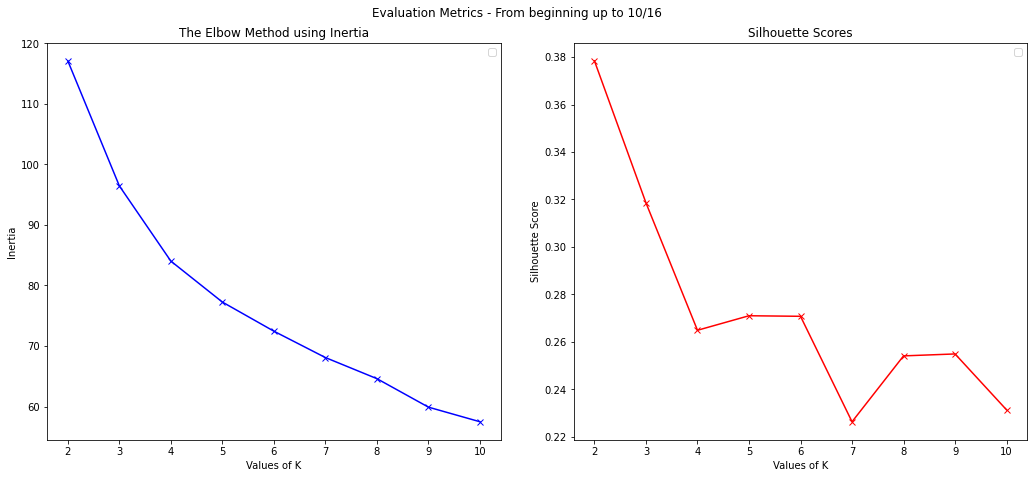

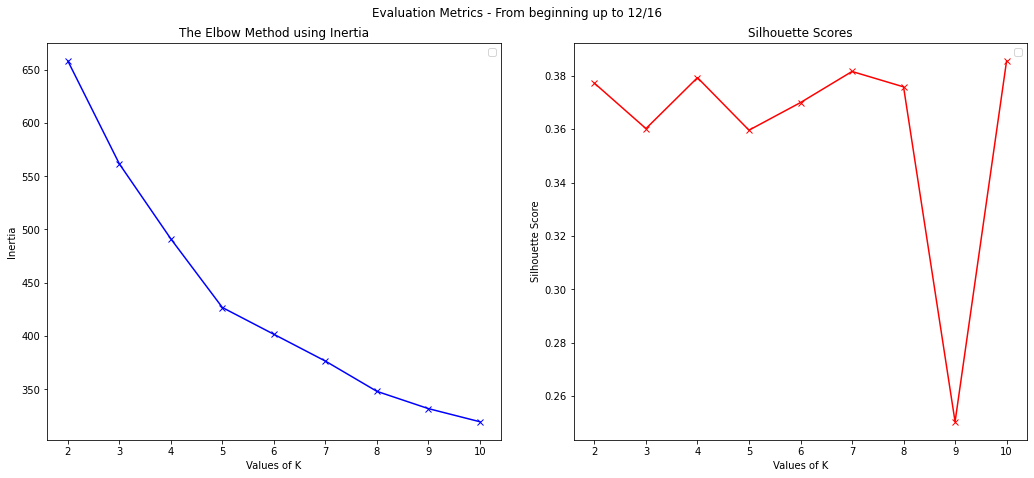

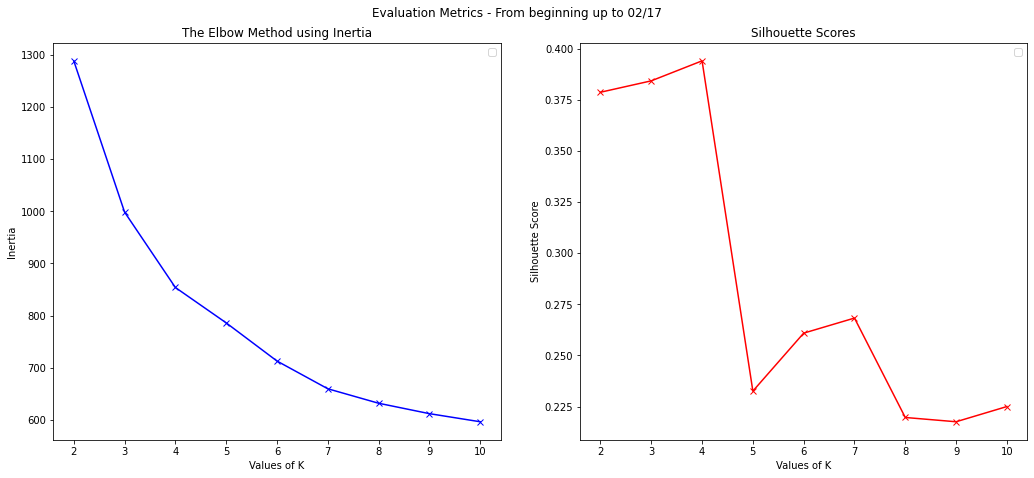

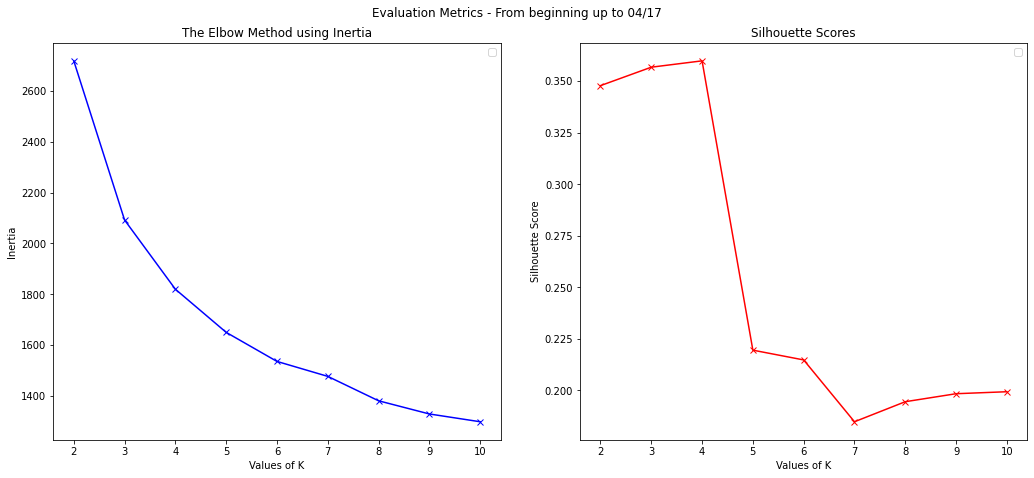

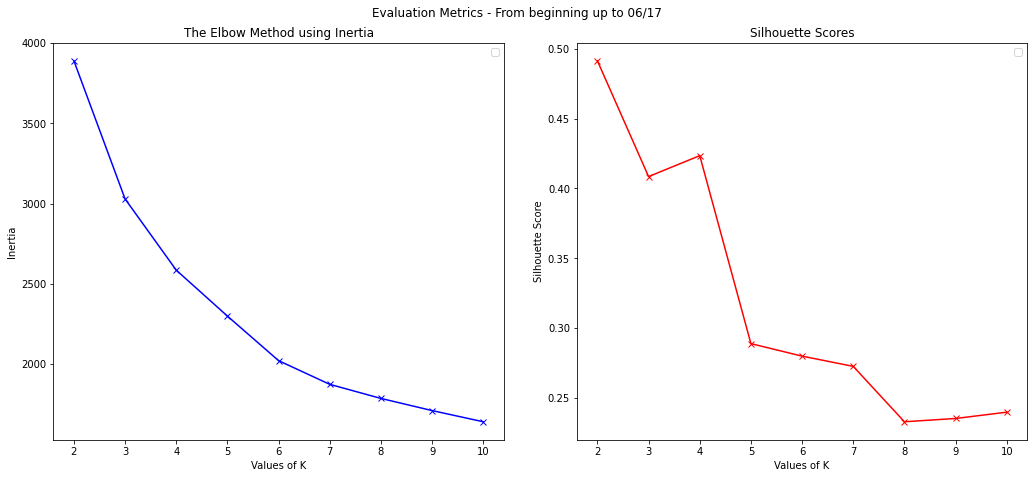

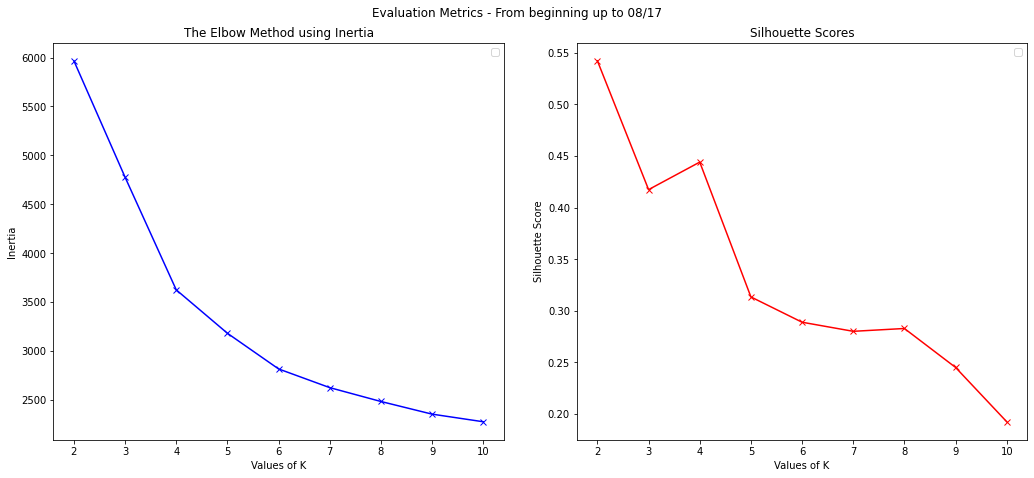

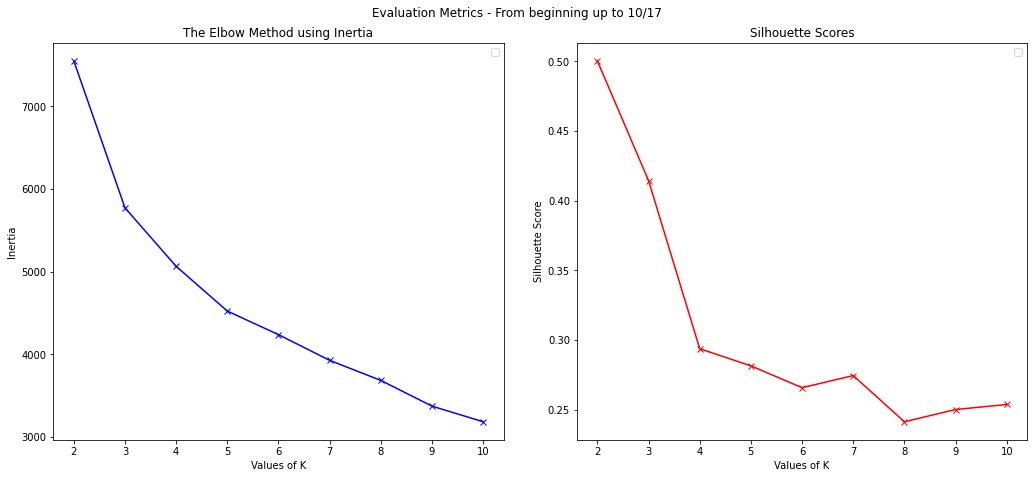

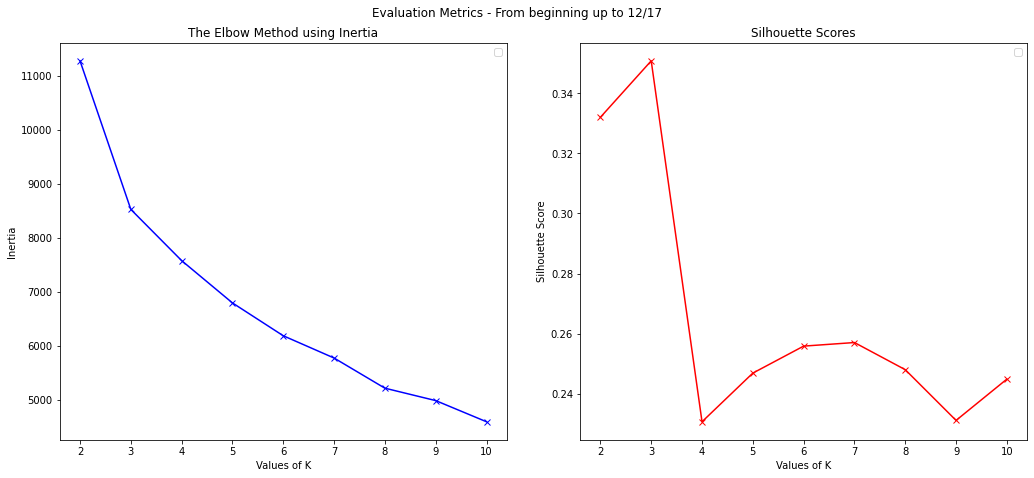

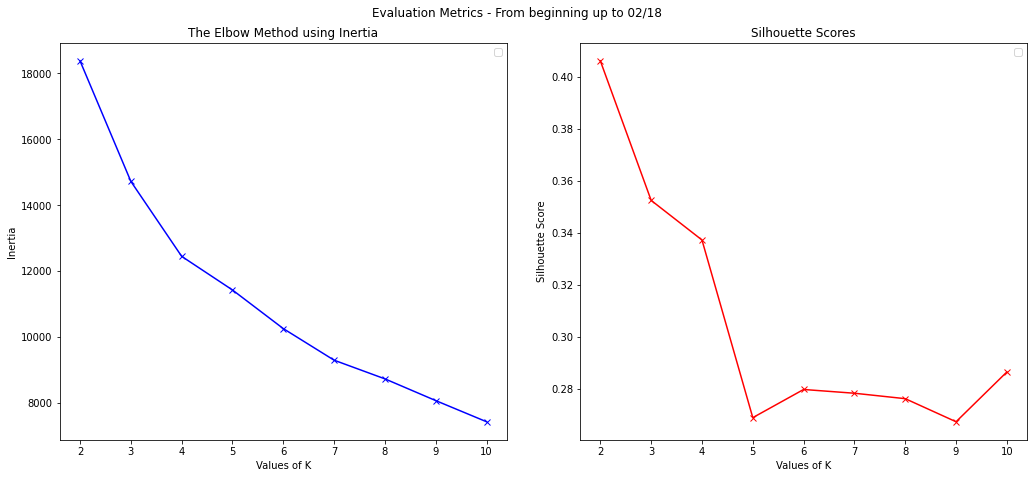

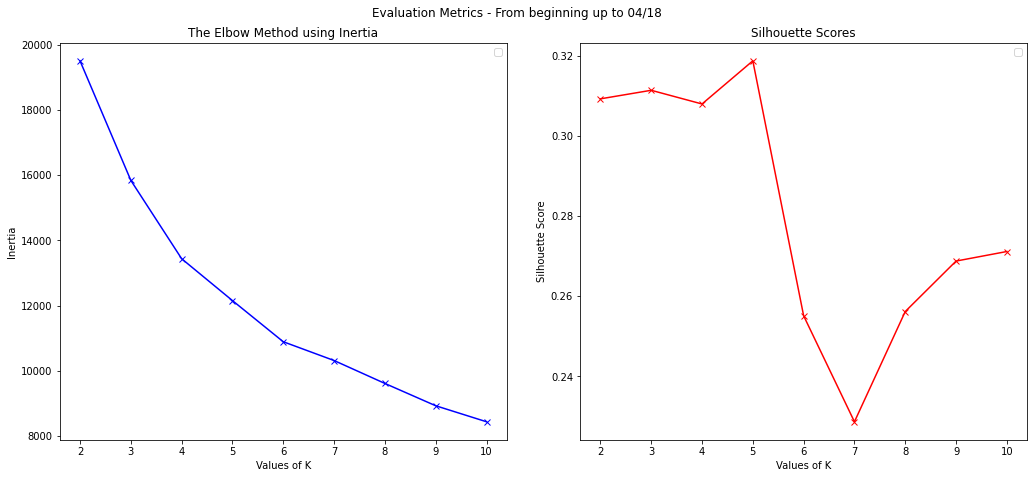

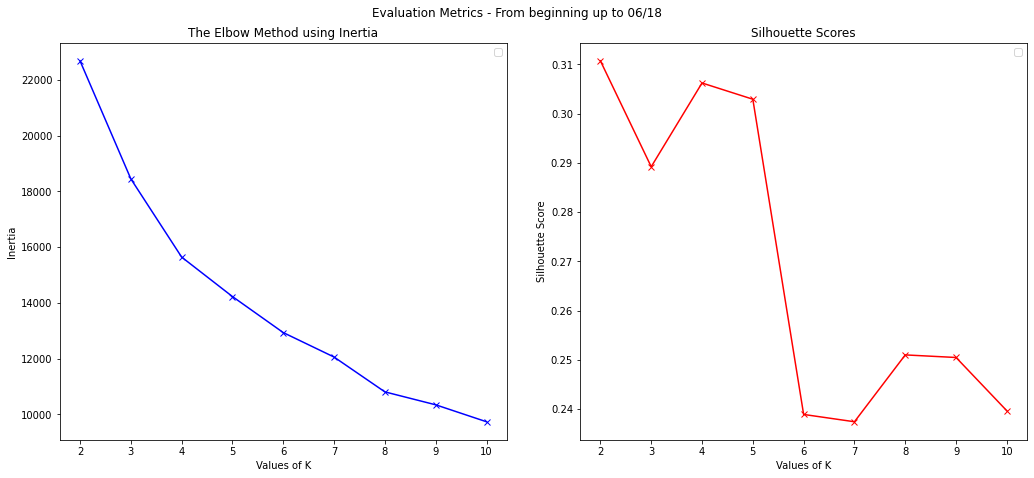

In [20]:
# Evaluation of Optimal number of clusters on the Chronologically cumulated datasets

from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

min_max_scaler = preprocessing.MinMaxScaler()

K = list(range(2,11))

InertiaAll = []
SilhouetteAll = []

for i in range(len(DataFrames)):
    
    print(i)
    
    Inertia = []
    Silhouette = []

    for ClustNumber in K:
    
        # I do a Kmeans to Identify Clusters
    
        ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

        X = DataFrames[i][ColumnSelection]
    
        X_scaled = min_max_scaler.fit_transform(X)

        Kmeans = KMeans(n_clusters=ClustNumber, random_state=0, n_init=10).fit(X_scaled)
    
        Silhouette_score = silhouette_score(X_scaled, Kmeans.labels_, metric='euclidean')
    
        Inertia.append(Kmeans.inertia_)
        Silhouette.append(Silhouette_score)

    InertiaAll.append(Inertia)
    SilhouetteAll.append(Silhouette)
    
    title = 'Evaluation Metrics - From beginning up to ' + Dates[i] 
    
    fig, axs = plt.subplots(1, 2)

    fig.set_figheight(7)
    fig.set_figwidth(15)

    fig.suptitle(title)

    axs[0].plot(K, Inertia, 'bx-')
    axs[0].legend()
    axs[0].set(title='The Elbow Method using Inertia', xlabel='Values of K', ylabel='Inertia')


    axs[1].plot(K, Silhouette, 'rx-')
    axs[1].legend()
    axs[1].set(title='Silhouette Scores',xlabel='Values of K', ylabel='Silhouette Score')

    fig.tight_layout(pad=3.0)
    fig.show()

0


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032]]
[[0.36567600560090624, 0.33365576011569437, 0.35996659015679233, 0.20943852095292026, 0.2562526836657301, 0.23461446117791507, 0.23023403345141552, 0.24798277098530552, 0.24156945001951027]]
1
[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757]]
[[0.36567600560090624, 0.33365576011569437, 0.35996659015679233, 0.20943852095292026, 0.2562526836657301, 0.23461446117791507, 0.23023403345141552, 0.24798277098530552, 0.24156945001951027], [0.3149095352298888, 0.32465969269439027, 0.22342538259794517, 0.2410785942

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2


No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155]]
[[0.36567600560090624, 0.33365576011569437, 0.35996659015679233, 0.20943852095292026, 0.2562526836657301, 0.23461446117791507, 0.23023403345141552, 0.24798277098530552, 0.24156945001951027], [0.3149095352298888, 0.32465969269439027, 0.22342538259794517, 0.24107859427841896, 0.2572902760167701, 0.2600383668269418, 0.243950968126255, 0.2515460829218191, 0.25040400713603955], [0.2821729702055203, 0.296430210236731, 0.3211552116279933, 0.3383756283487676, 0.2586940628

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309]]
[[0.36567600560090624, 0.33365576011569437, 0.35996659015679233, 0.20943852095292026, 0.2562526836657301, 0.23461446117791507, 0.23023403345141552, 0.24798277098530552, 0.24156945001951027], [0.3149095352298888, 0.32465969269439027, 0.22342538259794517, 0.24107859427841896, 0.257290276016770

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902]]
[[0.36567600560090624, 0.33365576011569437, 0.35996659015679233, 0.20943852095292026, 0.2562526836657301, 0.23461446

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

No handles with labels found to put in legend.
No handles with labels found to put in legend.


[[2699.292914604922, 2199.9688218320443, 1898.9122359107062, 1742.5863802549773, 1504.9347666959939, 1376.9653247137571, 1286.3653708684142, 1216.7038681594843, 1169.8908346639032], [6843.021381682924, 5514.377604412897, 4880.150734326892, 4262.143099881269, 3805.581914520675, 3435.9975196298697, 3256.6725181795814, 3092.2627134304284, 2952.7562748126757], [12334.8968108028, 9941.542059581521, 8246.222607642792, 7411.397255996558, 6618.577056857296, 6040.14142293666, 5558.5193239758755, 5155.595502459074, 4914.2881497906155], [15836.441372705916, 13047.146437126832, 11219.512433353462, 10141.594467561772, 9279.084741000595, 8520.97647104636, 8376.446936374965, 7654.461465747404, 7270.942161055309], [18040.596219955485, 15008.813052156016, 12757.626211440445, 11329.71959124274, 10305.662335468109, 9651.249389539193, 9258.078545645156, 8775.08450217565, 7895.194740539902], [21094.831061189227, 17297.596562779836, 14733.44566037092, 13213.770456285789, 12040.91890824595, 11359.96204647940

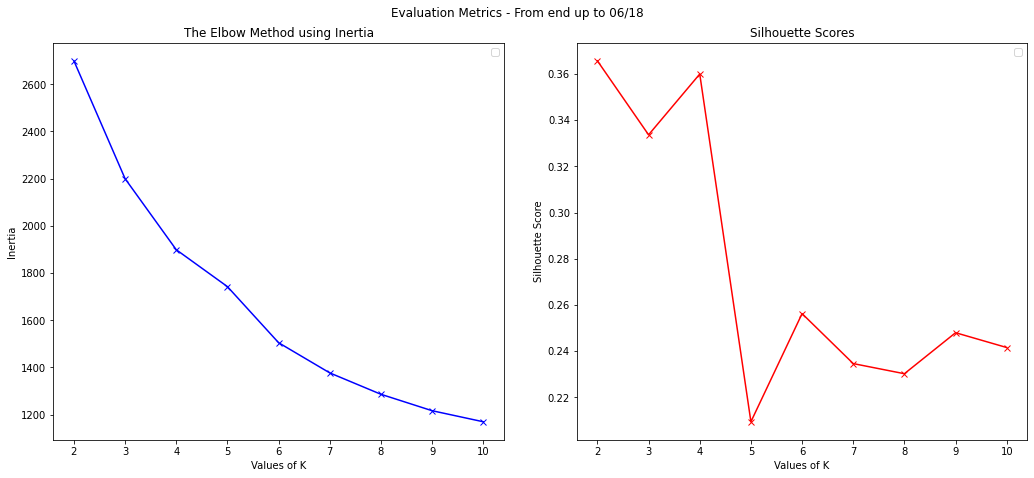

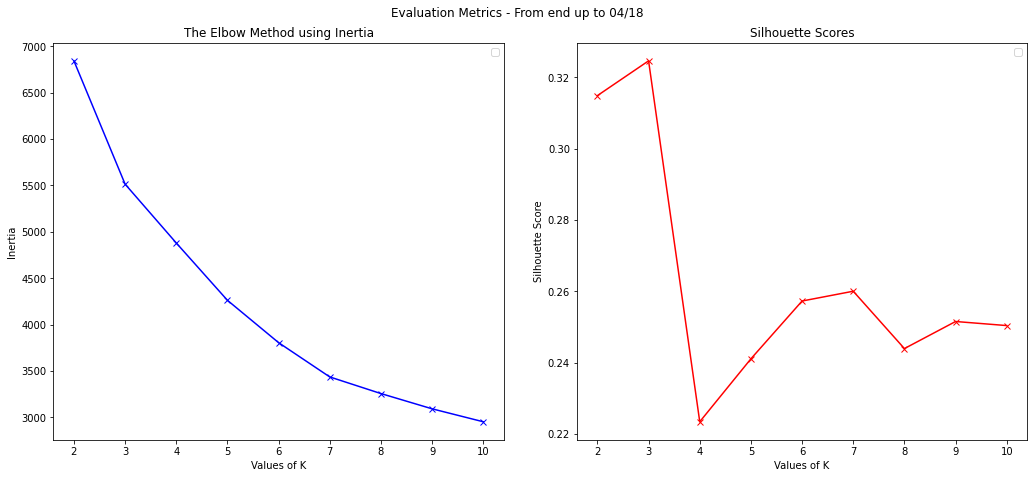

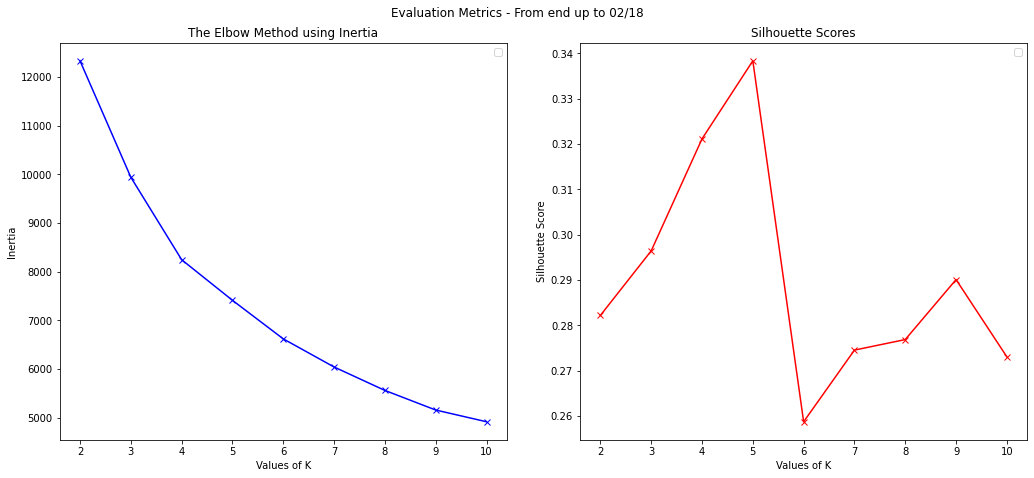

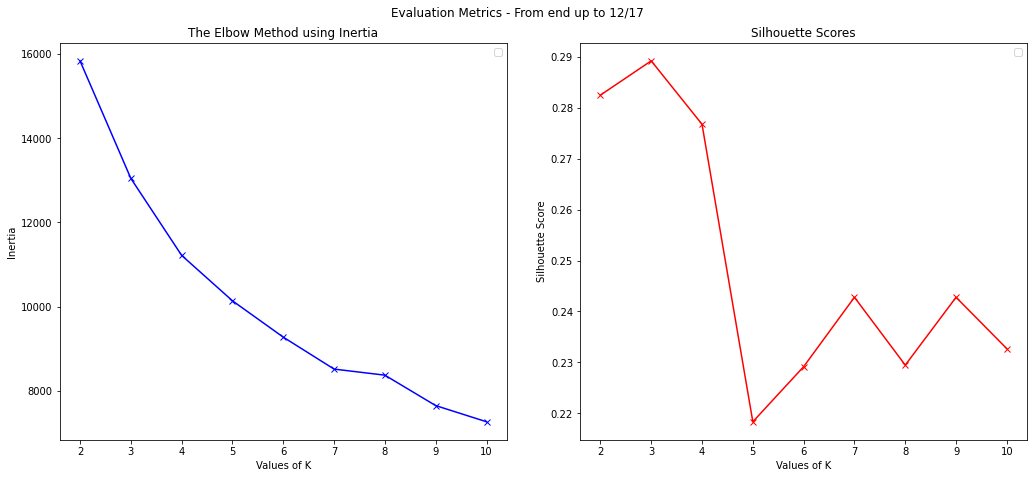

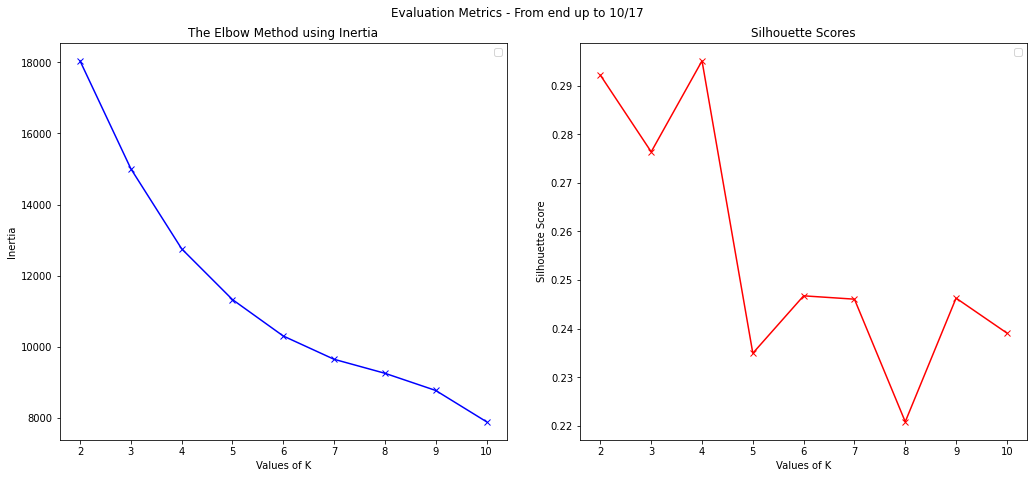

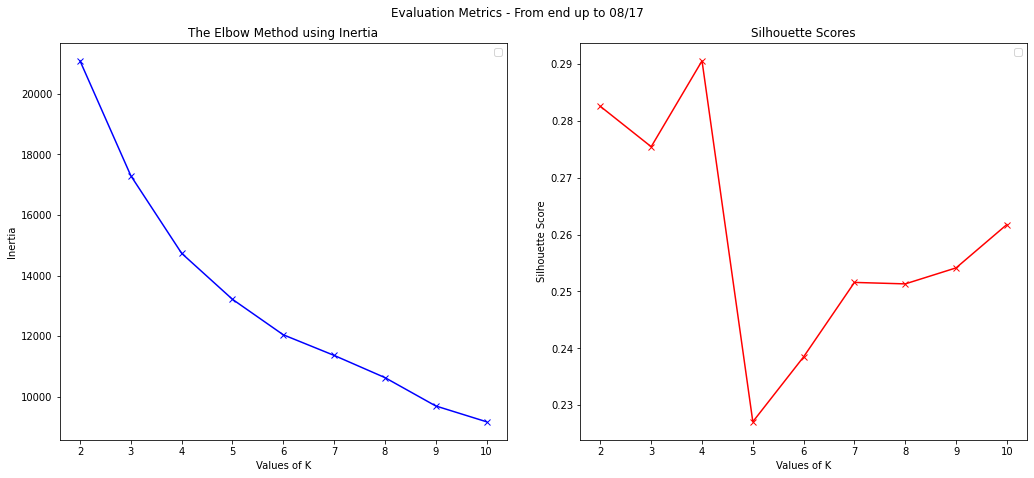

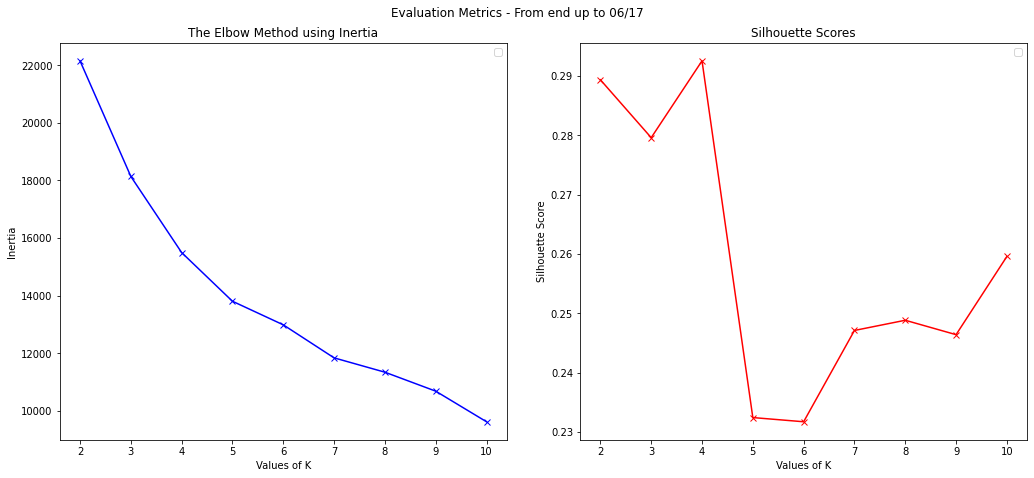

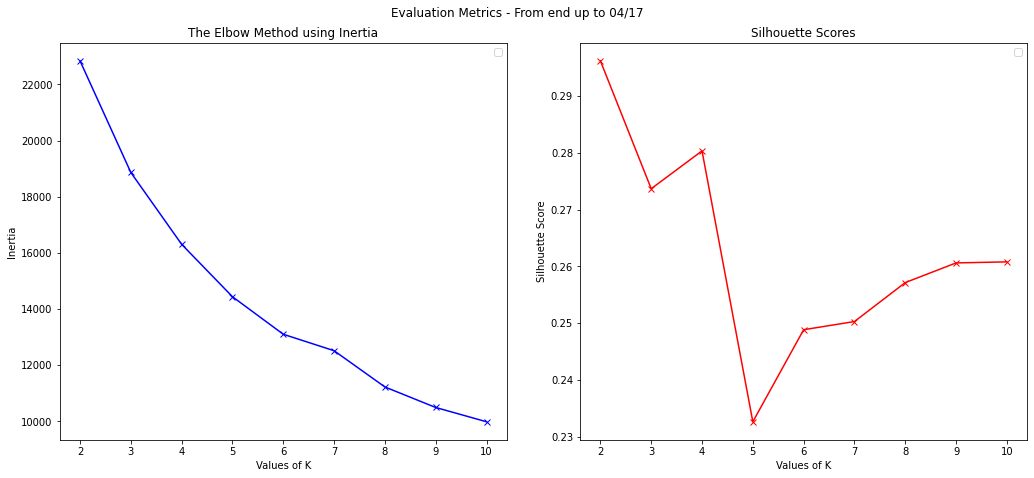

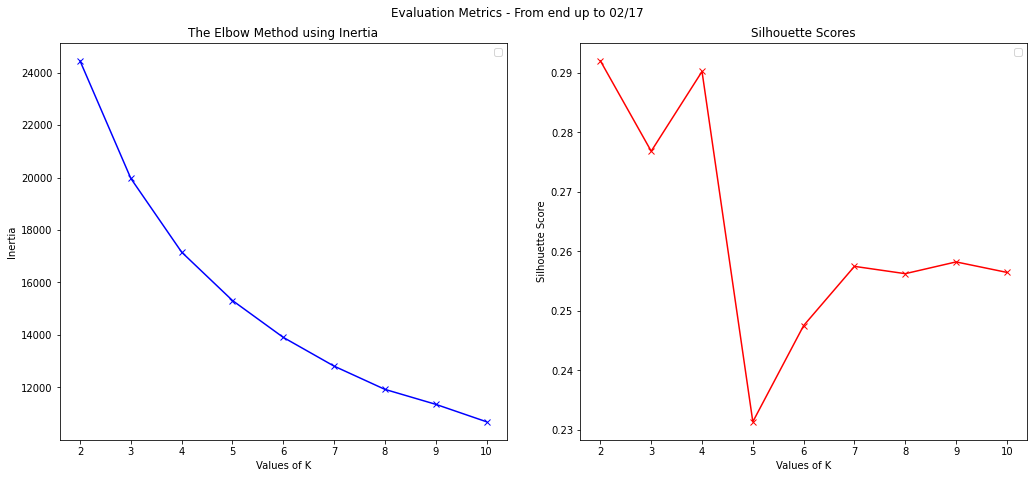

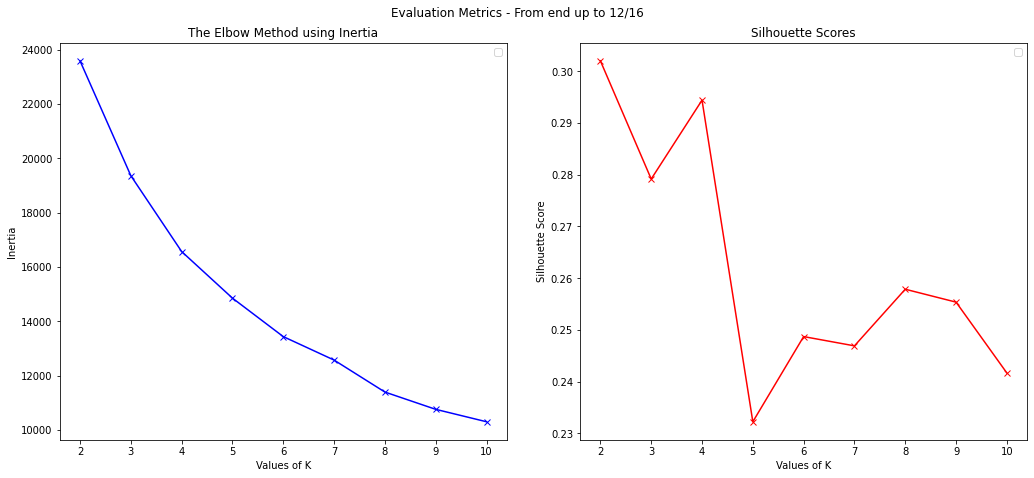

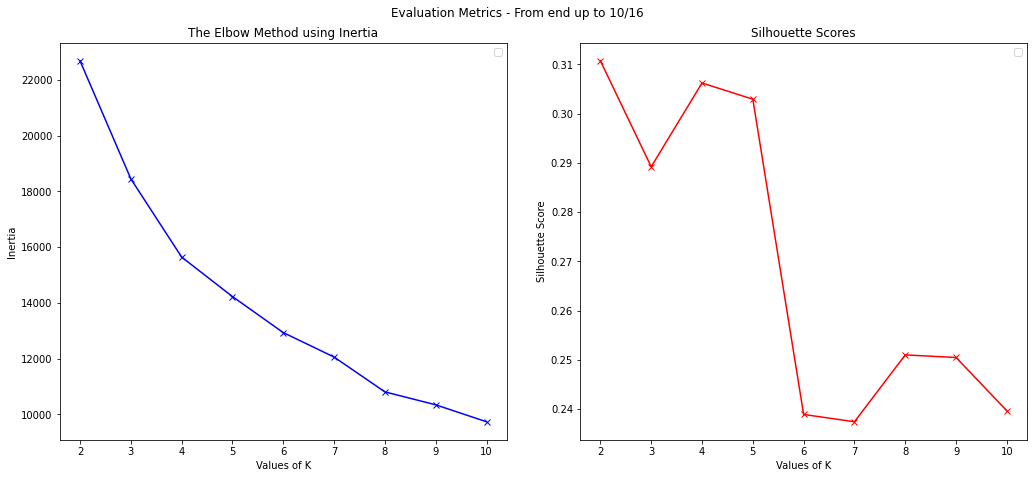

In [21]:
# Evaluation of Optimal number of clusters on the Anti-Chronologically cumulated datasets

from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

min_max_scaler = preprocessing.MinMaxScaler()

K = list(range(2,11))

InertiaAll = []
SilhouetteAll = []

for i in range(len(DataFrames_Latest)):
  print(i)
  Inertia = []
  Silhouette = []

  for ClustNumber in K:
    # I do a Kmeans to Identify Clusters
    ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

    X = DataFrames_Latest[i][ColumnSelection]
    X_scaled = min_max_scaler.fit_transform(X)

    Kmeans = KMeans(n_clusters=ClustNumber, random_state=0, n_init=10).fit(X_scaled)
    Silhouette_score = silhouette_score(X_scaled, Kmeans.labels_, metric='euclidean')
    Inertia.append(Kmeans.inertia_)
    Silhouette.append(Silhouette_score)

  InertiaAll.append(Inertia)
  print(InertiaAll)
  SilhouetteAll.append(Silhouette)
  print(SilhouetteAll)
  title = 'Evaluation Metrics - From end up to ' + Dates[-i-1] 
  fig, axs = plt.subplots(1, 2)

  fig.set_figheight(7)
  fig.set_figwidth(15)

  fig.suptitle(title)

  axs[0].plot(K, Inertia, 'bx-')
  axs[0].legend()
  axs[0].set(title='The Elbow Method using Inertia', xlabel='Values of K', ylabel='Inertia')

  axs[1].plot(K, Silhouette, 'rx-')
  axs[1].legend()
  axs[1].set(title='Silhouette Scores',xlabel='Values of K', ylabel='Silhouette Score')

  fig.tight_layout(pad=3.0)
  fig.show()


Je choisi 4 clusters, car (hormis avec 2) c'est avec 4 clusters que j'obtiens le Silouette score le plus élevé lorsqu'on prends un grand nombre de données.

Ci-dessous je fais un K-means avec 4 clusters, puis je représente ces clusters sur un tSNE en 2 dimmensions. Le tSNE calcule pour chaque point (ici les clients) sa distance Euclidienne avec tous les autres points (les autres clients) dans l'espace mutlidimensionnel. Ensuite il établit une matrice de similarité entre les clients, et il cherche à créer un graphique en dimmension inférieure (ici 2 dimmensions), de sorte à ce que les clients similaires (selon la matrice de similarité) soient proches, et les clients dissimilaires soient éloignés.

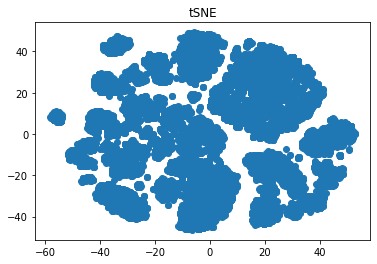

No handles with labels found to put in legend.


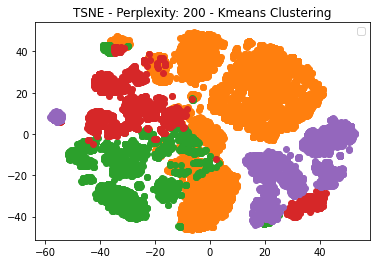

In [12]:
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

X = DataFrames_Latest[3][ColumnSelection]

min_max_scaler = preprocessing.MinMaxScaler()

X_scaled = min_max_scaler.fit_transform(X)

X_embedded = TSNE(n_components=2, perplexity=200, n_iter=1000).fit_transform(X_scaled)

First = []
Second = []
    
for i in range(len(X_embedded)):
    First.append(X_embedded[i][0])
    Second.append(X_embedded[i][1])
    
    
DataFrames_Latest[3]['TSNE_1'] = First
DataFrames_Latest[3]['TSNE_2'] = Second
        

plt.scatter(First, Second)
plt.title('tSNE - Perplexity: 200')
plt.show()
                                                                                         

for i in range(-1, DataFrames_Latest[3]['Categories_3'].max()+1):
    plt.scatter(DataFrames_Latest[3]['TSNE_1'][DataFrames_Latest[3]['Categories_3'] == i], DataFrames_Latest[3]['TSNE_2'][DataFrames_Latest[3]['Categories_3'] == i])

plt.title('tSNE - Perplexity: 200 - Kmeans Clustering')
plt.legend()    
plt.show()  

## 4. Evaluation de la stabilité des clusters dans le temps


Ici je cherche à vérifier dans quelle mesure les données plus anciennes, permettent de prédire les clusters sur des données plus récente.

Je prends par exemple les données les plus anciennes, je fit un K-means sur ces données (le K-means détermine les centroides et les frontières des clusters), puis j'utilise ce K-means "fitté" sur les données les plus anciennes, pour prédire les clusters sur des données plus récentes.

Ensuite, je fit un nouveau K-means directement sur les données plus récentes, et je prédit les clusters sur les données plus récentes.

Enfin, je compare les résultats des 2 prédictions (lorsque le K-means est fitté sur des anciennes données, et lorsque le K-means est fitté sur la base de donnée courrante) avec un Rand Index score.

In [8]:
# Create function which identifies identical clusters, despite their labels being different

def ReCode_Clusters(DataFrame, Test_Clusters, Train_Clusters):
    
    # Measure similarity of clusters accross Trainning set and Test set

    Similarities = []

    for i in range(DataFrame[Train_Clusters].max()+1):
        Blank = []
        for j in range(DataFrame[Test_Clusters].max()+1):
            AInterB = len(DataFrame[(DataFrame[Train_Clusters] == i) & (DataFrame[Test_Clusters] == j)])
            AUnionB = len(DataFrame[DataFrame[Train_Clusters] == i]) + len(DataFrame[DataFrame[Train_Clusters] == j]) - AInterB
            if AUnionB != 0:
              Rand = AInterB / AUnionB
            if AUnionB == 0:
              Rand = 0
            Blank.append(Rand)
        Similarities.append(Blank)
    
    # Create New variable where 'Clusters_Train' is coded like 'Clusters_Test'

    DataFrame['Clusters_Train2'] = -1
    
    for h in range(DataFrame[Train_Clusters].max()+1):
        for i in range(DataFrame[Train_Clusters].max()+1):
            for j in range(DataFrame[Test_Clusters].max()+1):
                if (Similarities[i][j] == max(list(map(max, *Similarities)))) & (Similarities[i][j] > 0):
                    DataFrame['Clusters_Train2'][DataFrame[Train_Clusters] == i] = j
                    for z in range(len(Similarities)):
                        Similarities[z][j] = 0
                        Similarities[i][z] = 0
                        
    DataFrame[Train_Clusters] = DataFrame['Clusters_Train2']
    del DataFrame['Clusters_Train2']
    
    return DataFrame

J'utilise ici les données cumulées chronologiquement (la tranche la plus ancienne, puis les 2 tranches les plus anciennes, puis les 3 tranches les plus anciennes...)

J'utilise chaque sommes de tranches, pour "fitter" les K-means, puis je prédis les clusters dans les autres sommes de tranches.

Par exemple, j'utilise la tranche la plus ancienne pour fitter le K-means, puis je prédis les clusters sur toutes les sommes de tranches subséquentes. Cela me permettra de vérifier si le "fitting" sur la tranche la plus ancienne permet de prédire correctement les clusters des sommes de tranches plus récentes.

J'utilise le Rand Index pour mesurer la proportion de points qui sont clusterisés identiquement, sur le nombre total de points.

In [9]:
ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

RandIndices = []

for j in range(len(DataFrames)):
    
    X = DataFrames[j][ColumnSelection]
    
    X_scaled = min_max_scaler.fit_transform(X)

    Latest_Kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(X_scaled)
    
    DataFrames[j]['Categories'] = Latest_Kmeans.labels_

    RandIndex = []

    for i in range(len(DataFrames)):
        
        ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

        X = DataFrames[i][ColumnSelection]
    
        X_scaled = min_max_scaler.fit_transform(X)

        Kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(X_scaled)
    
        DataFrames[i]['Categories_' + str(j)] = Latest_Kmeans.predict(X_scaled)
        DataFrames[i]['Categories_' + str(i)] = Kmeans.labels_

        ReCode_Clusters(DataFrames[i], 'Categories_' + str(i), 'Categories_' + str(j))
    
        DataFrames[i]['Errors_' + str(j)] = DataFrames[i]['Categories_' + str(j)] - DataFrames[i]['Categories_' + str(i)]
        DataFrames[i]['Errors_' + str(j)][DataFrames[i]['Errors_' + str(j)] != 0] = 1
    
        RandIndex.append(1- DataFrames[i]['Errors_'+ str(j)].mean())
   
    RandIndices.append(RandIndex)
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

Ci-dessous je montre sur un graphique, les performances des prédictions lorsque je "fit" le K-means sur les données allant jusqu'à Décembre 2016 (Bleu), lorsque je fit le K-means sur les donénes allant jusqu'à Avril 2017 (Orange), et lorsque je fit le K-means sur les données allant jusqu'à Décembre 2017 (Vert).

Par exemple, pour la courbe bleu, je fit un K-means sur les données allant jusqu'à Décembre 2016, puis je compare avec un K-means fitté sur les données allant jusqu'à Décembre 2016 (forcémenet 100% identique). Puis j'utilise ce même fitting, pour prédire les clusters sur les données allant jusqu'à Février 2017, et je compare avec les clusters du Kmeans "fitté" sur les données allant jusqu'à Février 2017 (Environ 80% des points sont dans les mêmes clusters, et 20% dans des clusters différents). Ensuite j'utilise toujours le K-means fitté sur les données allant jusqu'à Décembre 2016, pour prédire les clusters sur les données allant jusqu'à Avril 2017, et je compare avec les prédictions d'un K-means fitté sur les données allant jusqu'à Avril 2017 (moins de 60% des points sont considérés comme étant dans les mêmes clusters, et donc plus de 40% dans des points sont considérés comme étant dans des clusters différents).

De manière générale, ces graphqiues montrent que plus le temps passe, plus les K-means fittés sur des données antérieures proposent une clusterisation imprécise des points, comparé à un K-means fitté sur les donénes allant jusqu'à la date la plus récente. 


Text(0.5, 0, 'Customer Last Purchase')

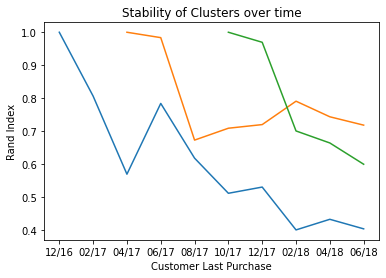

In [ ]:
plt.plot(Dates[1:], RandIndices[1][1:])
plt.plot(Dates[3:], RandIndices[3][3:])
plt.plot(Dates[6:], RandIndices[6][6:])


plt.title('Stability of Clusters over time')
plt.ylabel("Rand Index")
plt.xlabel("Customer Last Purchase")

Si le clustering n'est pas mis à jour sous 2 mois entre 2.5% et 20% des clients seront mal-clusterisés.

Si le clustering n'est pas mis à jour sous les 4 mois, entre 35% et 45% des points seront mal-clusterisés.

Il est donc conseillé de faire une mise à jour du clustering tous les 2 mois pour des performances optimales, et il est impératif de mettre à jour le clustering avant 4 mois.

Ci-dessous, je fais un diagramme de Sankey pour vérifier plus précisément comment les clusters ont évolué dans les 4 derniers mois.

A présent je me focalise sur les tranches de données cumulées Anti-chronologiquement (Tranche la plus récente, 2 tranches les plus récentes, 3 tranches les plus récentes...).

A l'inverse de ce que j'ai présenté précédemment, ici je "fit" le K-means sur les données les plus récentes, et je prédit les clusters sur toutes les tranches anti-cumulées plus anciennes.

Par exemple, je fit sur le K-means sur les plus récentes commandes à jusqu'à Juin 2018, puis je prédit les clusters sur les données allant de la plus récente commande jusqu'à Avril 2018, puis de même jusqu'à Février 2018, puis de même jusqu'à Décembre 2017.

In [11]:
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

RandIndices = []

for j in range(len(DataFrames_Latest)):
  X = DataFrames_Latest[j][ColumnSelection]

  min_max_scaler = preprocessing.MinMaxScaler()

  X_scaled = min_max_scaler.fit_transform(X)

  Latest_Kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(X_scaled)
  DataFrames_Latest[j]['Categories'] = Latest_Kmeans.labels_

  RandIndex = []

  for i in range(len(DataFrames_Latest)):
    ColumnSelection = ['Frequency', 'NumRecency', 'Amount', 'Mean_review_score', 'City_Frequency', 'City_NumRecency', 'City_Amount', 'City_Review', 'State_Frequency', 'State_NumRecency', 'State_Amount', 'State_Review', 'Payment_Type_Frequency', 'Payment_Type_NumRecency', 'Payment_Type_Amount', 'Payment_Type_Review', 'Category_Frequency', 'Category_NumRecency', 'Category_Amount', 'Category_Review']

    X = DataFrames_Latest[i][ColumnSelection]
    X_scaled = min_max_scaler.fit_transform(X)

    Kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(X_scaled)
    DataFrames_Latest[i]['Categories_' + str(j)] = Latest_Kmeans.predict(X_scaled)
    DataFrames_Latest[i]['Categories_' + str(i)] = Kmeans.labels_

    ReCode_Clusters(DataFrames_Latest[i], 'Categories_' + str(i), 'Categories_' + str(j))
    DataFrames_Latest[i]['Errors_' + str(j)] = DataFrames_Latest[i]['Categories_' + str(j)] - DataFrames_Latest[i]['Categories_' + str(i)]
    DataFrames_Latest[i]['Errors_' + str(j)][DataFrames_Latest[i]['Errors_' + str(j)] != 0] = 1
    RandIndex.append(1- DataFrames_Latest[i]['Errors_'+ str(j)].mean())
    RandIndices.append(RandIndex)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Pour établir un diagram de Sankey, je compte le nombre d'individus qui ont été clusteristé dans chaque cluster (0 à 3) lorsque le K-means a été fitté sur les données les plus récentes, et qui ont été clusterisés dans le même cluster ou dans n'importe quel autre cluster (0 à 3) lorsque le "fitting" du K-means est effectué sur les données un peu plus anciennes (des plus récentes commandes à Avril 2018).

In [ ]:
NumberOfClusters = 4

Labels = ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
Source = []
Target = []
Value = []
X = [0,0,0,0]
Y = [0, 0.33, 0.66, 1.0]

print(len(DataFrames_Latest)-1)
import numpy as np

for t in range(8,10):
  b = t - 8
  Labels = Labels + ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3',]
  for i in range(NumberOfClusters):
    for j in range(NumberOfClusters):
      a = len(DataFrames_Latest[t][(DataFrames_Latest[t]['Categories_' +str(t)] == i) & (DataFrames_Latest[t]['Categories_' +str(t+1)] == j)]) /len(DataFrames_Latest[t])
      if a != 0:
        Source.append(i+4*(b))
        Target.append(j+4*(b+1))
        Value.append(a)

print('X = ', X)
print('Y = ', Y)
print(len(Labels), Labels)
print(len(Source), Source)
print(len(Target), Target)
print(len(Value), Value)


10
X =  [0, 0, 0, 0]
Y =  [0, 0.33, 0.66, 1.0]
12 ['Cluster0', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster0', 'Cluster1', 'Cluster2', 'Cluster3', 'Cluster0', 'Cluster1', 'Cluster2', 'Cluster3']
16 [0, 0, 1, 1, 2, 2, 3, 3, 3, 4, 4, 4, 5, 6, 7, 7]
16 [4, 5, 5, 6, 6, 7, 4, 5, 7, 8, 9, 11, 9, 10, 9, 11]
16 [0.5093831775700934, 0.0008473520249221184, 0.12013707165109035, 1.2461059190031153e-05, 0.15865420560747664, 1.2461059190031153e-05, 0.0012834890965732087, 0.001221183800623053, 0.20844859813084113, 0.2077710363424649, 0.0012012012012012011, 0.0002083716369430655, 0.5090641662070233, 0.1589262732119875, 3.6771465342893915e-05, 0.12279217993503708]


In [ ]:
# Sankey Diagram


import plotly.graph_objects as go



fig = go.Figure(data=[go.Sankey(
    node = {
      "pad" : 15,
      "thickness" : 20,
      "line" : dict(color = "black", width = 0.5),
      "label" : Labels
    },
    link = dict(
      source = Source,
      target  = Target,
      value = Value
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()


On voit sur ce Diagram de Sankey, que lorsque le fitting du K-means est effectué sur les donénes les plus récentes, et prédit sur les données un peu plus anciennes, certains individidus sont clusterisés différememnet.

Un faible nombre d'individus passent d'un cluster à un autre selon la période de fitting du K-means.

En revanche, on remarque que la taille du Cluster 0 et du Cluster 1 ont varié entre les 2 périodes. 

L'avantage de Ce diagram est aussi de voir que les erreurs de Clustering, n'affectent pas toutes les catégories de la même manière. Les clusters 2 et 3 sont relativement stables (quel que soit la date de prédiction du K-means), alors que les cluster 1 et 2 changent en taille entre les 2 dates de prédiction.


On recommande donc de faire une mise à jour du clustering tous les 2 mois, car les erreurs observés peuvent toucher exclusivement un seul cluster, et donc donner des résultats très mauvais sur ce cluster, tout en laissant les autres clusters inchangés.

## 5. Description des Clusters

Je fais des graphiques de Radar, sur les 4 clusters lorsque le K-means est fitté sur toutes les données les plus récentes (seulement 2018).

J'y décrit leur distribution sur:
  - les dimensions RFM + Satisfaction

Ensuite pour mieux identifiés ces clients, je décrit leurs distributions sur:
  - les 10 villes les plus grandes
  - les 10 types de produits les plus achetés
  - Tous les moyens de paiement employés

In [24]:
Recency = 3

Radar = []

for i in range(DataFrames_Latest[Recency]['Categories_' + str(Recency)].max()+1):
  bla = []
  bla.append(DataFrames_Latest[Recency]['NumRecency'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i].mean())
  bla.append(DataFrames_Latest[Recency]['Frequency'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i].mean())
  bla.append(DataFrames_Latest[Recency]['Amount'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i].mean())
  bla.append(DataFrames_Latest[Recency]['Mean_review_score'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i].mean())
  Radar.append(bla)

print(Radar)

Means = []

for i in range(4):
  Means.append((Radar[0][i] + Radar[1][i] + Radar[2][i] + Radar[3][i] ) / 4)
print(Means)

RadarNorm = []

for i in range(4):
  bla = []
  for j in range(4):
    bla.append(Radar[i][j]/Means[j])
  RadarNorm.append(bla)

print(RadarNorm[0])
print(RadarNorm[1])
print(RadarNorm[2])
print(RadarNorm[3])

print(max(RadarNorm[0]))
print(max(RadarNorm[1]))
print(max(RadarNorm[2]))
print(max(RadarNorm[3]))

[[888.2413880660177, 1.029792636479052, 130.79596614472325, 4.640313161235717], [889.0020417422868, 1.028584392014519, 152.11363883847028, 4.576381957047792], [868.5907655286509, 1.0163934426229508, 146.41759362310478, 1.4044467839775407], [883.5467140319715, 1.0265245707519242, 107.18391711072076, 4.571866982435366]]
[882.3452273422317, 1.0253237604671115, 134.12777892925476, 3.7982522211741037]
[1.0066823739065787, 1.0043585023426207, 0.9751594128290989, 1.2216969519210386]
[1.0075444556096331, 1.0031800994701636, 1.1340949656573536, 1.2048652091969698]
[0.9844114736643258, 0.99129024588283, 1.0916276612642057, 0.3697613276306866]
[1.0013616968194625, 1.0011711523043858, 0.7991179602493421, 1.2036765112513053]
1.2216969519210386
1.2048652091969698
1.0916276612642057
1.2036765112513053


In [25]:
import plotly.express as px
import pandas as pd

categories = ['Recency','Frequency','Amount', 'Satisfaction']

fig = go.Figure()


fig.add_trace(go.Scatterpolar(
      r=RadarNorm[0],
      theta=categories,
      fill='toself',
      name='Cluster 0',
))
fig.add_trace(go.Scatterpolar(
      r=RadarNorm[1],
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=RadarNorm[2],
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=RadarNorm[3],
      theta=categories,
      fill='toself',
      name='Cluster 3'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.3]
    )),
  showlegend=True
)

fig.show()


Remarque que 3 clusters se distinguent sur le montant dépensé (Cluster 1 > Cluster 0 > Cluster 3).

On remarque surtout que le Cluster 2 se distingue très fortement par sont niveau d'insatisfaction.

A présent, utilisons la distribution des clusters sur les moyens de paiement, les villes, et les types de produits, pour déterminer ce qui peux expliquer ces différences.

In [14]:
def BigCategorySelection(DataFrame, variable):
    Categories = DataFrame[variable].unique()
    
    CategorySize = []

    for i in range(len(Categories)):
        CategorySize.append(len(DataFrame[variable][DataFrame[variable] == Categories[i]]))
    
    zipped_lists = zip(CategorySize, Categories)
    
    sorted_pairs = sorted(zipped_lists)

    tuples = zip(*sorted_pairs)
    
    list1, list2 = [ list(tuple) for tuple in  tuples]

    BigCategories = []
    
    if len(Categories) > 10:
        MaxCategories = 11
    if len(Categories) <= 10:
        MaxCategories = len(Categories)
        
    for i in range(MaxCategories):
        BigCategories.append(list2[-i-1])
        
    return BigCategories
        

# Create a list with only the top 10 cities

BigCities = BigCategorySelection(NewIndividuals, 'City')

# Create a list with only the top 10 States

BigStates = BigCategorySelection(NewIndividuals, 'State')

# Create a list with only the top 10 Payment Methods

BigPaymentTypes = BigCategorySelection(NewIndividuals, 'Payment_Type')

# Create a list with only the top 10 Product Types

BigProductTypes = BigCategorySelection(NewIndividuals, 'Category')

In [18]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

Recency = 3

RadarPaymentTypes = []

for i in range(DataFrames_Latest[Recency]['Categories_' + str(Recency)].max()+1):
  bla = []
  for j in range(len(BigPaymentTypes)):
    top = len(DataFrames_Latest[Recency][(DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i) & (DataFrames_Latest[Recency]['Payment_Type'] == BigPaymentTypes[j])])
    bottom = len(DataFrames_Latest[Recency]['NumRecency'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i])
    bla.append(top / bottom)
  RadarPaymentTypes.append(bla)

print(RadarPaymentTypes)

Means = []

for i in range(len(BigPaymentTypes)):
  Means.append((RadarPaymentTypes[0][i] + RadarPaymentTypes[1][i] + RadarPaymentTypes[2][i] + RadarPaymentTypes[3][i]) / 4)

print(Means)

RadarPaymentTypesNorm = []

for i in range(4):
  bla = []
  for j in range(len(BigPaymentTypes)):
    bla.append(RadarPaymentTypes[i][j]/Means[j])
  RadarPaymentTypesNorm.append(bla)

print(max(RadarPaymentTypesNorm[0]))
print(max(RadarPaymentTypesNorm[1]))
print(max(RadarPaymentTypesNorm[2]))
print(max(RadarPaymentTypesNorm[3]))

[[0.973338975878121, 0.0, 0.026661024121878967, 0.0], [0.9557622504537205, 0.01678765880217786, 0.027450090744101634, 0.0], [0.7989171303955482, 0.17340953526846142, 0.01879981952173259, 0.008873514814257783], [0.0, 0.9429248075784488, 0.0, 0.057075192421551214]]
[0.6820045891818474, 0.28328050041227204, 0.018227733596928298, 0.016487176808952248]
1.462662594891766
1.5059519384641145
1.1714248599909753
3.461792948721238


In [19]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

categories = BigPaymentTypes

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=RadarPaymentTypesNorm[0],
      theta=categories,
      fill='toself',
      name='Cluster 0'
))
fig.add_trace(go.Scatterpolar(
      r=RadarPaymentTypesNorm[1],
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=RadarPaymentTypesNorm[2],
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=RadarPaymentTypesNorm[3],
      theta=categories,
      fill='toself',
      name='Cluster 3'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 3.5]
    )),
  showlegend=False
)

fig.show()



Le cluster 2 (insatisfait), utilise un peu tous les moyens de paiments (vert).

Les cluster 1 et 0 (les 2 qui dépensent le plus) utilisent seulement des cartes de crédit et de débit.

Le cluster 3 (qui dépense le moins) utilise des "vouchers" et "boletto".



Conclusion: les "vouchers" et "boletto" sont surtout utilisé pour passer des petites commandes.

In [ ]:
import plotly.express as px
import pandas as pd

Recency = 3

RadarCities = []

for i in range(DataFrames_Latest[Recency]['Categories_' + str(Recency)].max()+1):
  bla = []
  for j in range(len(BigCities)):
    bla.append(len(DataFrames_Latest[Recency][(DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i) & (DataFrames_Latest[Recency]['City'] == BigCities[j])]) / len(DataFrames_Latest[Recency]['NumRecency'][DataFrames_Latest[Recency]['Categories_' + str(Recency)] == i]))
  RadarCities.append(bla)

Means = []

for i in range(len(BigCities)):
  Means.append((RadarCities[0][i] + RadarCities[1][i] + RadarCities[2][i] + RadarCities[3][i]) / 4)
print(Means)

RadarCitiesNorm = []

for i in range(4):
  bla = []
  for j in range(len(BigCities)):
    bla.append(RadarCities[i][j]/Means[j])
  RadarCitiesNorm.append(bla)

print(RadarCitiesNorm[0])
print(RadarCitiesNorm[1])
print(RadarCitiesNorm[2])
print(RadarCitiesNorm[3])

print(max(RadarCitiesNorm[0]))
print(max(RadarCitiesNorm[1]))
print(max(RadarCitiesNorm[2]))
print(max(RadarCitiesNorm[3]))



[0.12782633145593036, 0.09362900062647779, 0.024463060630845468, 0.01949776384375741, 0.012908524415521639, 0.012189603117285716, 0.01171641046531223, 0.01834153830807827, 0.009630209580437223, 0.007775236895141365, 0.006487943083425105]
[1.8533133213889343, 0.0, 1.6088236254697161, 1.5887755710194926, 1.7670483914371142, 1.6907355094971013, 1.3039138614958559, 0.0, 1.9643011133619488, 1.7852395193790156, 1.8915910259137134]
[0.0, 2.5368495277758862, 0.0, 0.0, 0.0, 0.0, 0.0, 2.4861006914941814, 0.0, 0.0, 0.017483218576859097]
[0.9553870960873071, 0.950944094876376, 1.2972250623730663, 1.2573218576646288, 0.9670416044935679, 0.90069336097766, 1.6045716030000485, 1.0167860869851282, 1.0151291173516819, 0.8897907134277493, 0.649074678787865]
[1.191299582523759, 0.5122063773477378, 1.0939513121572175, 1.1539025713158781, 1.2659100040693176, 1.4085711295252388, 1.0915145355040958, 0.4971132215206908, 1.0205697692863698, 1.3249697671932352, 1.4418510767215624]
1.9643011133619488
2.5368495277

In [ ]:
import plotly.express as px
import pandas as pd

categories = BigCities

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=RadarCitiesNorm[0],
      theta=categories,
      fill='toself',
      name='Cluster 0'
))
fig.add_trace(go.Scatterpolar(
      r=RadarCitiesNorm[1],
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=RadarCitiesNorm[2],
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=RadarCitiesNorm[3],
      theta=categories,
      fill='toself',
      name='Cluster 3'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 2.6]
    )),
  showlegend=False
)

fig.show()



Le cluster 2 (insatisfait) habite d'avantage à Porto Allegre que les autres groupes.

Le Cluster 1 (qui dépense le plus) habite d'avantage à Rio de Janeiro et Salvador (de très loin) que les autres groupes.

Le Cluster 3 (qui dépense le moins) est celui qui habite le moins à Rio de Janeiro et Salvador).

Conclusion: les cleints qui dépensent le plus sont concentrées sur Rio de Janeiro et Salvador. L'insatisfcation (cluster 2) des disproportionnée à Porto Allegre (il faudrait vérifer s'il n'y a pas des problèmes de livraison sur cette ville).

In [ ]:
import plotly.express as px
import pandas as pd

Recency = 3

RadarProductTypes = []

for i in range(DataFrames_Latest[Recency]['Categories_'  + str(Recency)].max()+1):
  bla = []
  for j in range(len(BigProductTypes)):
    top = len(DataFrames_Latest[Recency][(DataFrames_Latest[Recency]['Categories_'  + str(Recency)] == i) & (DataFrames_Latest[Recency]['Category'] == BigProductTypes[j])])
    bottom = len(DataFrames_Latest[Recency]['NumRecency'][DataFrames_Latest[Recency]['Categories_'  + str(Recency)] == i])
    bla.append(top / bottom)
  RadarProductTypes.append(bla)

print(RadarProductTypes)

Means = []

for i in range(len(BigProductTypes)):
  Means.append((RadarProductTypes[0][i] + RadarProductTypes[1][i] + RadarProductTypes[2][i] + RadarProductTypes[3][i]) / 4)

print(Means)

RadarProductTypesNorm = []

for i in range(4):
  bla = []
  for j in range(len(BigProductTypes)):
    bla.append(RadarProductTypes[i][j]/Means[j])
  RadarProductTypesNorm.append(bla)

print(max(RadarProductTypesNorm[0]))
print(max(RadarProductTypesNorm[1]))
print(max(RadarProductTypesNorm[2]))
print(max(RadarProductTypesNorm[3]))



[[0.10279305966991113, 0.08819297503173931, 0.07553956834532374, 0.06724502750740584, 0.06077020736352095, 0.06859923825645366, 0.0524333474396953, 0.035844265763859504, 0.029707998307236565, 0.04672027084214981, 0.02738044858231062], [0.1124092558983666, 0.06783121597096188, 0.06749092558983666, 0.06771778584392014, 0.09471415607985481, 0.051497277676950996, 0.04514519056261343, 0.04900181488203267, 0.02926497277676951, 0.04650635208711434, 0.03289473684210526], [0.08677996691231764, 0.10542938787787637, 0.07189050985110543, 0.08076402466536321, 0.0755000751992781, 0.049781922093547905, 0.0490299293126786, 0.050684313430591064, 0.03083170401564145, 0.04722514663859227, 0.03098210257181531], [0.09733570159857904, 0.07673179396092362, 0.08052101835405566, 0.0852575488454707, 0.0522202486678508, 0.05352279455298994, 0.057548845470692715, 0.044760213143872116, 0.023564239194789817, 0.05186500888099467, 0.02699822380106572]]
[0.0998294960197936, 0.0845463432103753, 0.07386050553508038, 0.0

In [ ]:
categories = BigProductTypes

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=RadarProductTypesNorm[0],
      theta=categories,
      fill='toself',
      name='Cluster 0'
))
fig.add_trace(go.Scatterpolar(
      r=RadarProductTypesNorm[1],
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=RadarProductTypesNorm[2],
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=RadarProductTypesNorm[3],
      theta=categories,
      fill='toself',
      name='Cluster 3'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 1.4]
    )),
  showlegend=False
)

fig.show()



Le cluster 2 (insatisfait) achète un peu plus de "Casa mesa banho" que les autres groupes mais pas énormément.

Le cluster 1 (qui dépense le plus) achète des relogios presentes (orlogerie).

Le cluster 3 (qui dépense le moins) achète beaucoup moins de relogios presentes (orlogerie) et légèrement plus que la moyenne de "moveis_decoracao" (meubles décoration).

Conclusion: la vente d'orlogerie fait monter les dépenses individuelles, et les utilidades domesticas font baisser les dépenses individuelles.

## 6. Conclusion

J'ai fait un clustering RFM (Recency, Frequency, Amount) + Satisfaction + variables catégoriques (état, ville, moyen de payement, Type de produits).

J'ai cherché le nombre optimal de clusters. J'ai trouvé 4.
J'ai effectué une réduction de dimension avec un TSNE, et j'ai plotté les clients selon leur cluster sur un graphique en 2 dimensions. Dans l'ensemble les clusters semblent cohérents.


J'ai cherché à évaluer la stabilité des clusters dans le temps: je recommande une mise à jours tous les 2 mois pour une précision optimale des clusters. Bien que le nombre d'erreurs de clustering n'excede pas 20% dans les 2 mois, elles peuvent se concentrer intégralement sur un cluster, et donc rendre ce cluster obsolète ou absurde. Au bout de 4 mois, le taux d'erreur de clustering excède les 40%.


J'ai étudié le contenu des cluster et j'ai trouvé:
  - Cluster 2: insatisfait, habite disproportionément à Porto Allegre
  - Cluster 1: Dépense beaucoup, habite exclusivement à Rio de Janeiro et  à Salvador, achète d'avantage d'orlogerie que les autres groupes.
  - Cluster 3: Dépense le moins, utilise des moyens de payment atypique (boletto et vouchers).


### Recommandations à l'issue de ce Clustering: 

Vérifier pourquoi il y a une insatisfaction disproportionnée à Porte Allegre (peut-être un problème de livraison). Continuer de suggérer de l'orlogerie aux individus du cluster 1 (ceux qui dépensent le plus). Suggérer des produits peu couteux aux individus qui payent par moyens atypiques (boletto et vouchers).